In [3]:
import pandas as pd

Total features after one-hot encoding: 22345
Expected number of features: 61

--- Top 20 Features by Importance ---
                                                 Feature  Importance
10298                   Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
5215   Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
9395                     Census_PrimaryDiskTotalCapacity    0.010504
10299                            Census_TotalPhysicalRAM    0.009233
9132                  Census_OSInstallLanguageIdentifier    0.008208
295                    AVProductStatesIdentifier_53447.0    0.007858
431                                  AVProductsInstalled    0.007753
5216   Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5217     Census_InternalPrimaryDisplayResolutionVertical    0.006315
9403                           Census_ProcessorCoreCount

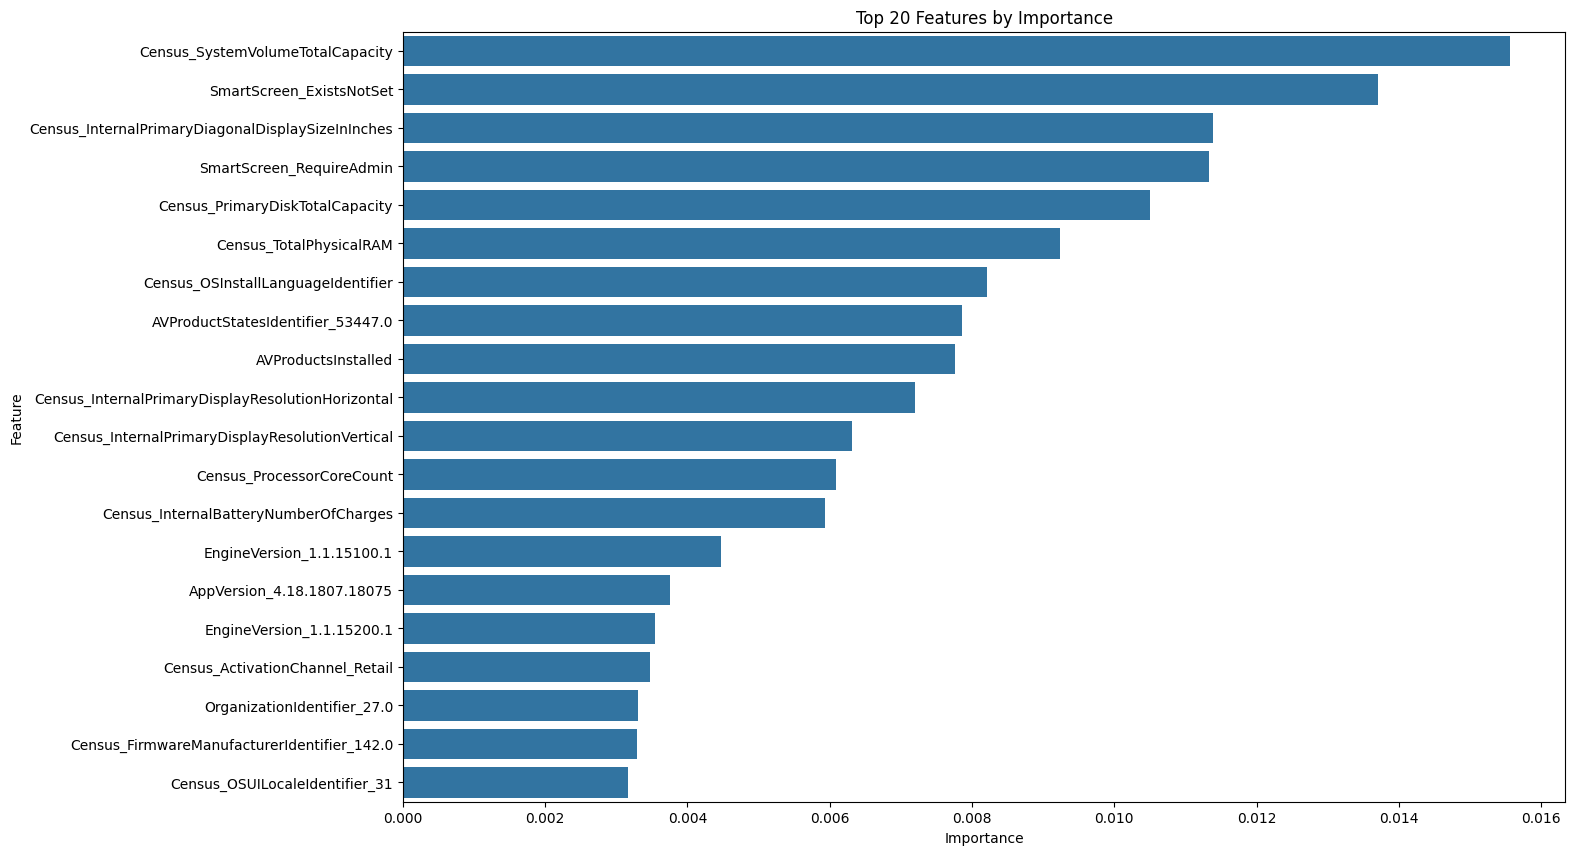


--- Top Rows with Missing Values ---
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScreen           3604               36.04
15                 OrganizationIdentifier           3028               30.28
29                                  SMode            609                6.09
14                         CityIdentifier            383                3.83
53  Census_InternalBatteryNumberOfChar

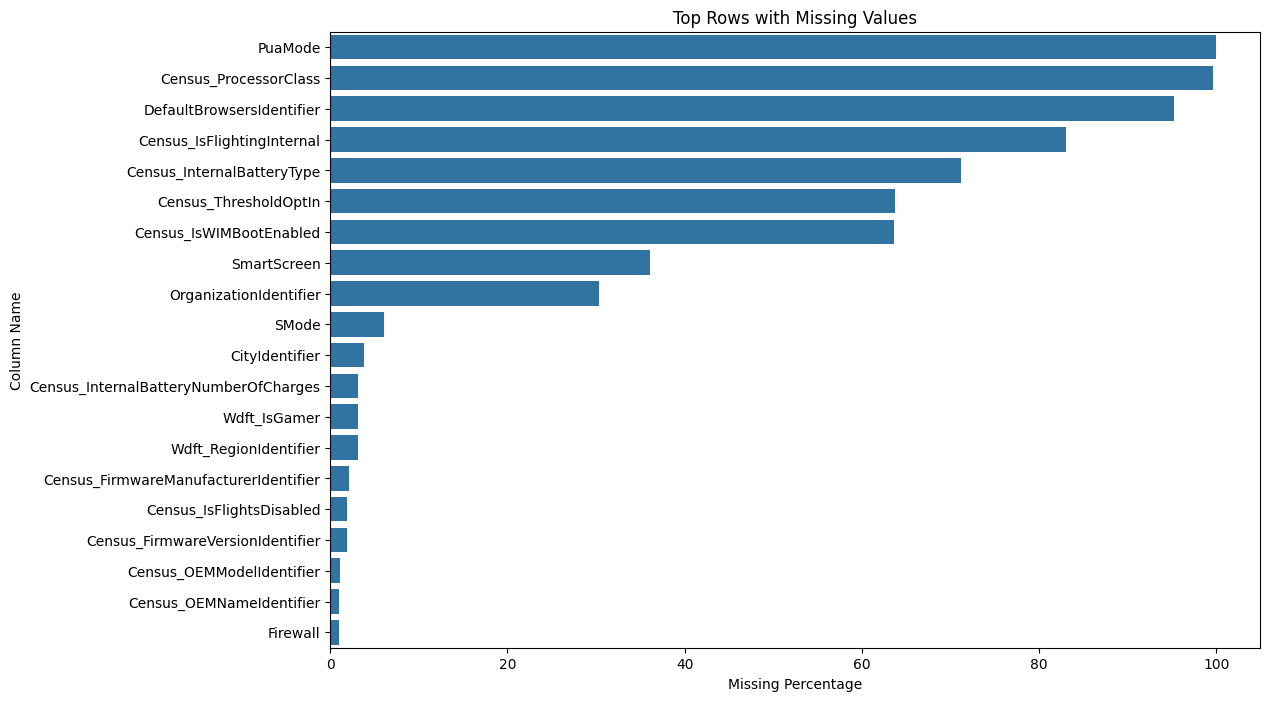

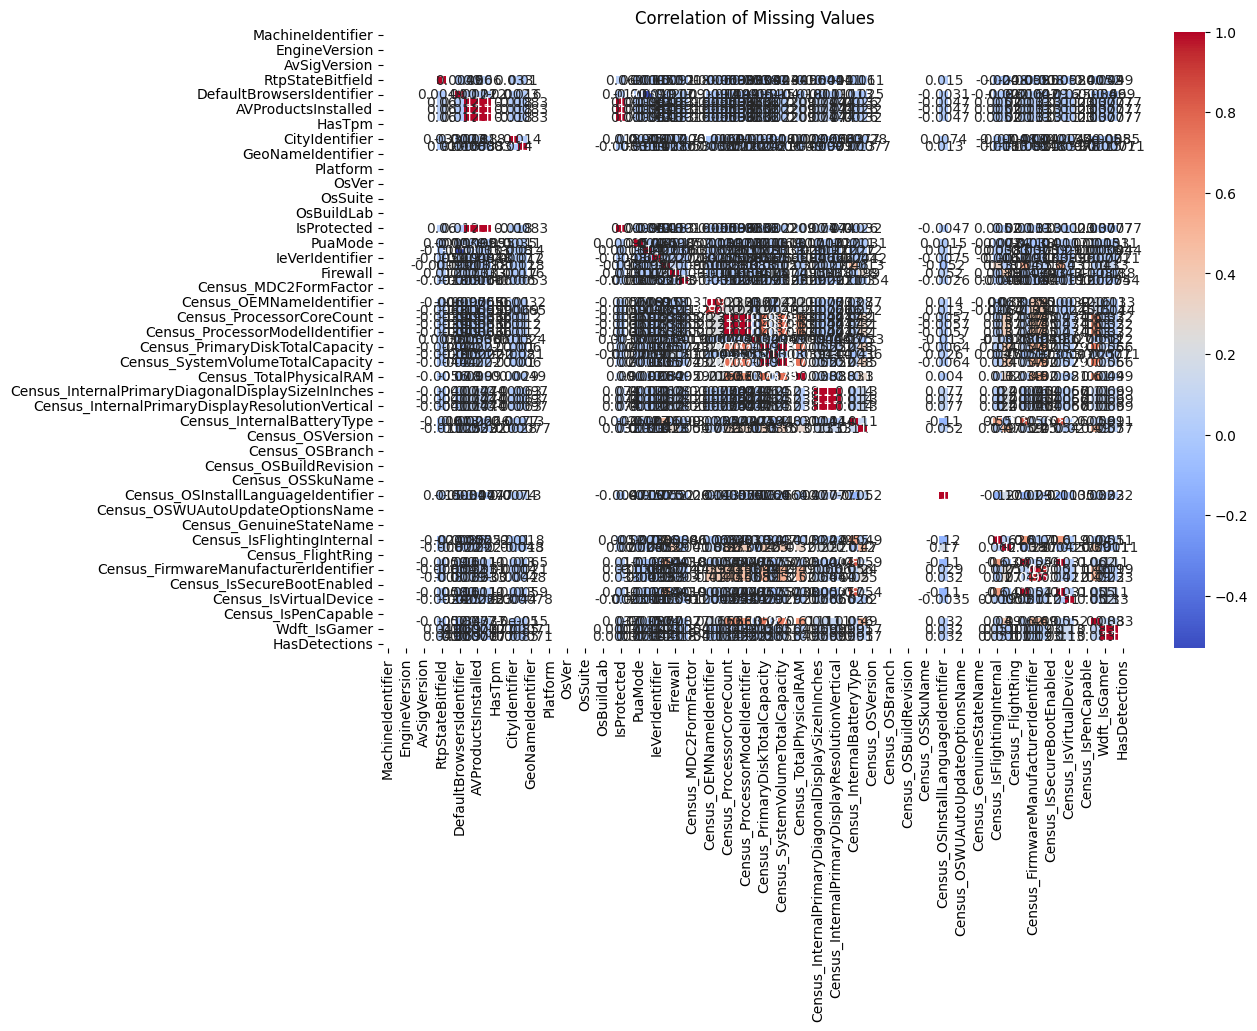

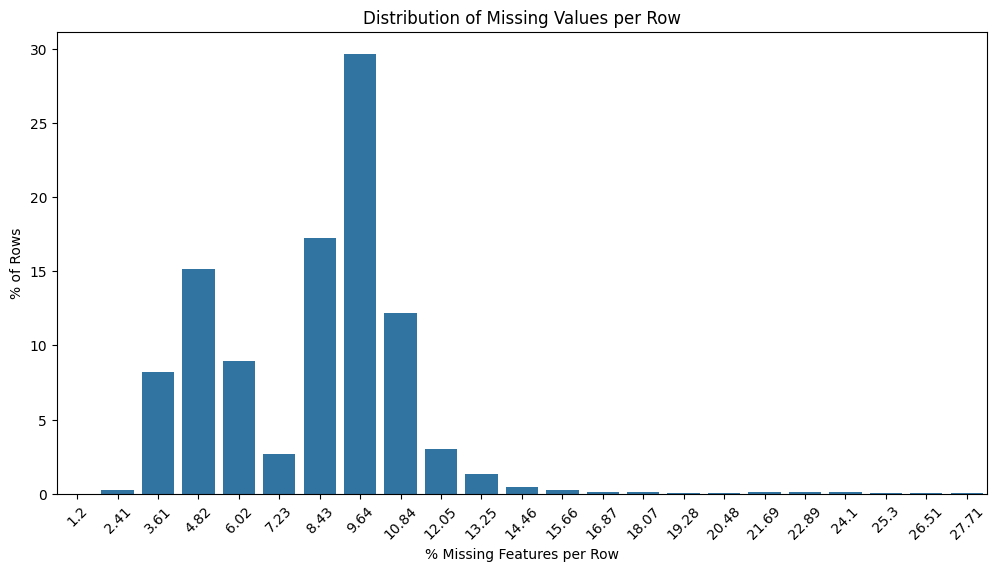


--- Distribution of Missing Values per Row ---
 missing features per row  % missing features per row  % of rows
                       23                   27.710843       0.03
                       22                   26.506024       0.02
                       21                   25.301205       0.05
                       20                   24.096386       0.10
                       19                   22.891566       0.11
                       18                   21.686747       0.13
                       17                   20.481928       0.04
                       16                   19.277108       0.05
                       15                   18.072289       0.10
                       14                   16.867470       0.13
                       13                   15.662651       0.25
                       12                   14.457831       0.42
                       11                   13.253012       1.33
                       10                 

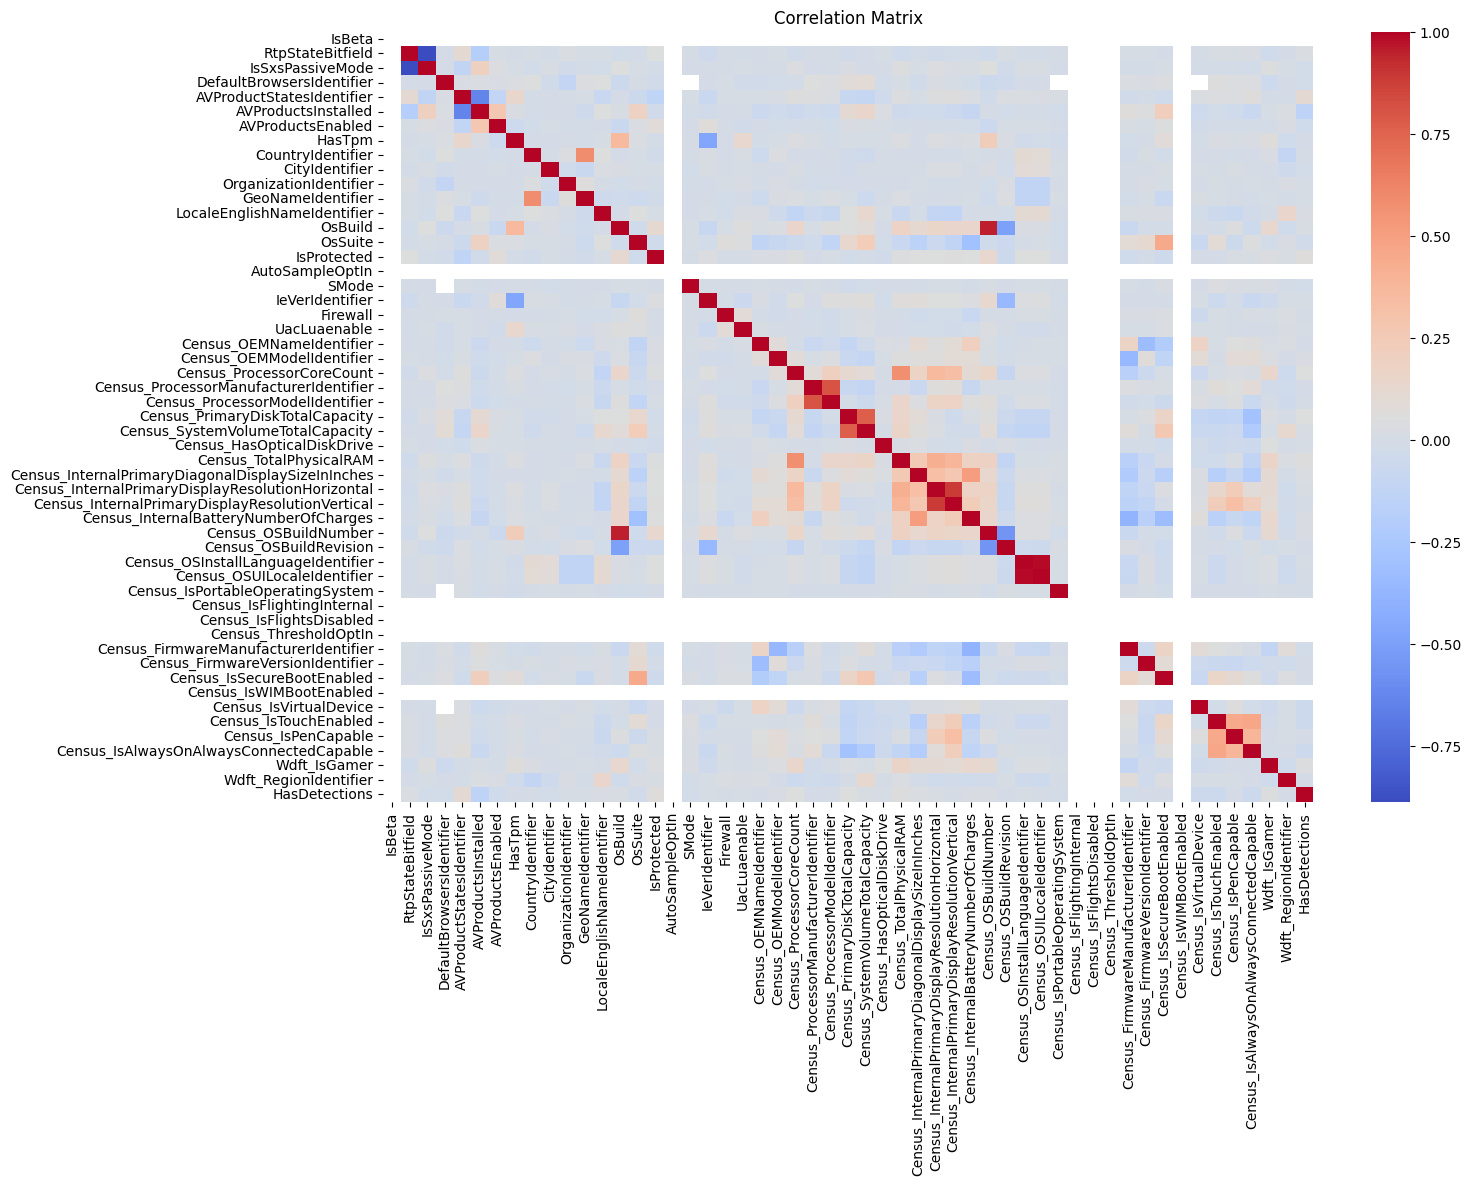


High Correlation Pairs (absolute value > 0.2 or < -0.2):

Census_OSUILocaleIdentifier                        Census_OSInstallLanguageIdentifier                   0.988793
Census_OSBuildNumber                               OsBuild                                              0.950950
Census_InternalPrimaryDisplayResolutionHorizontal  Census_InternalPrimaryDisplayResolutionVertical      0.885465
Census_ProcessorModelIdentifier                    Census_ProcessorManufacturerIdentifier               0.803918
Census_SystemVolumeTotalCapacity                   Census_PrimaryDiskTotalCapacity                      0.768164
CountryIdentifier                                  GeoNameIdentifier                                    0.585682
Census_ProcessorCoreCount                          Census_TotalPhysicalRAM                              0.579974
Census_InternalBatteryNumberOfCharges              Census_InternalPrimaryDiagonalDisplaySizeInInches    0.511199
Census_IsTouchEnabled                

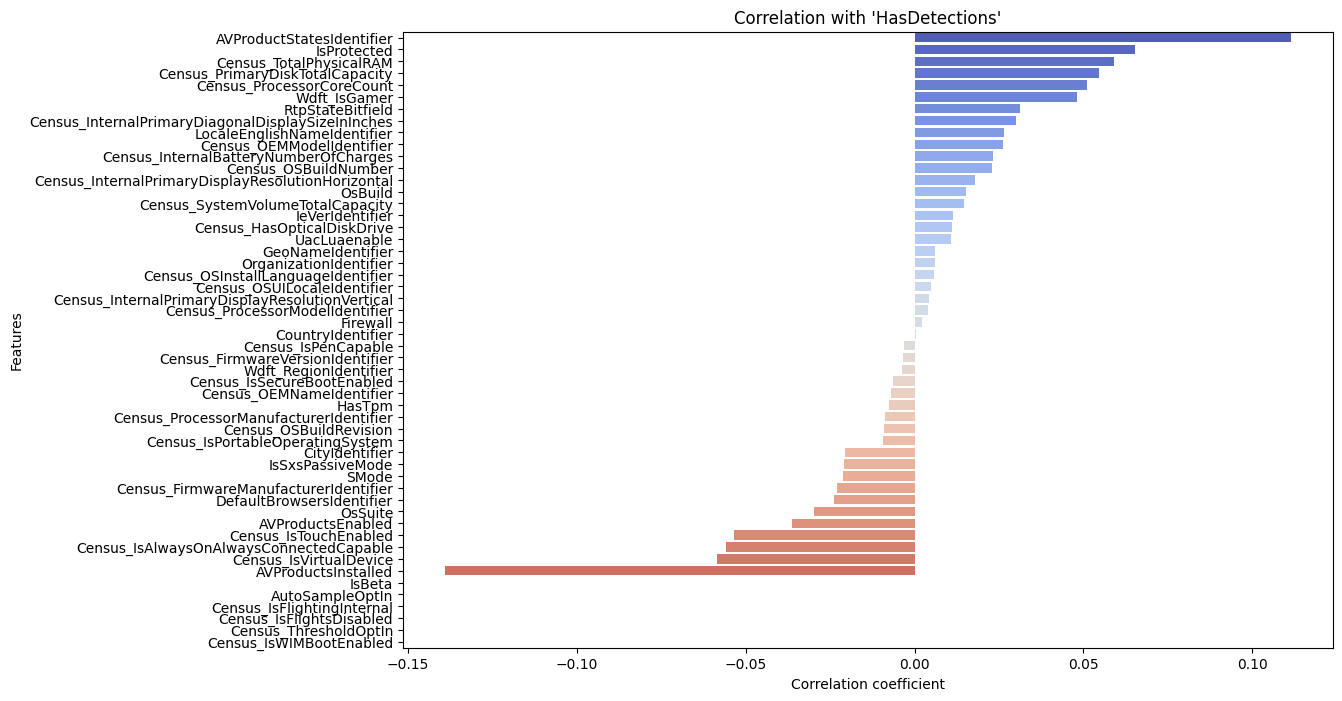


Correlation with 'HasDetections':
 AVProductStatesIdentifier                            0.111348
IsProtected                                          0.065207
Census_TotalPhysicalRAM                              0.059147
Census_PrimaryDiskTotalCapacity                      0.054558
Census_ProcessorCoreCount                            0.050934
Wdft_IsGamer                                         0.047980
RtpStateBitfield                                     0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.029988
LocaleEnglishNameIdentifier                          0.026584
Census_OEMModelIdentifier                            0.026206
Census_InternalBatteryNumberOfCharges                0.023367
Census_OSBuildNumber                                 0.022802
Census_InternalPrimaryDisplayResolutionHorizontal    0.017849
OsBuild                                              0.015204
Census_SystemVolumeTotalCapacity                     0.014634
IeVerIdentifier                   

In [5]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, ensure_directories_exist, save_feature_importance, save_json_file
from src.analysis.missing_values_analysis import (
    missing_values_summary,
    plot_missing_values,
    missing_values_correlation,
    plot_missing_values_correlation,
    missing_count_per_row,
    plot_missing_count_per_row,
    calculate_missing_values_correlation,
    high_missing_value_correlation_pairs,
    prepare_data_and_split,
    analyze_missing_values,
    analyze_missing_values_correlation,
    analyze_missing_values_pattern
)
from src.analysis.data_understanding import correlation_analysis
from src.model.missing_values_training import train_model_and_extract_feature_importance

def main():
    # Load paths and data
    paths = load_paths()
    ensure_directories_exist(paths)
    train_sample, test_sample = load_sample_data(nrows=10000)

    # Prepare data and split
    X_train, X_test, y_train, y_test, numeric_features, categorical_features, feature_metadata = prepare_data_and_split(train_sample, paths)

    # Train model and extract feature importance
    importance_df = train_model_and_extract_feature_importance(X_train, y_train, numeric_features, categorical_features, feature_metadata)
    
    # Display feature importance
    print("\n--- Top 20 Features by Importance ---")
    print(importance_df.head(20))
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(os.path.join(paths['reports']['figures']['missing_values'], 'feature_importance.png'))
    plt.show()
    save_feature_importance(importance_df, os.path.join(paths['reports']['analysis_results'], 'feature_importance.json'))

    # Perform Missing Values Analysis
    analyze_missing_values(train_sample, paths)

    # Correlation Analysis of Missing Values
    analyze_missing_values_correlation(train_sample, paths)

    # Pattern Analysis: Count of Missing Values per Row
    analyze_missing_values_pattern(train_sample, paths)

    # Calculate feature correlation matrix
    numeric_columns = train_sample.select_dtypes(include=['int64', 'float64']).columns
    feature_corr_matrix = train_sample[numeric_columns].corr()

    # Use correlation_analysis function to find high correlation pairs for features
    high_corr_pairs, _ = correlation_analysis(dataframe=train_sample)

    # Save high correlation pairs
    high_corr_pairs_dict = {str(k): v for k, v in high_corr_pairs.to_dict().items()}
    save_json_file(high_corr_pairs_dict, os.path.join(paths['reports']['analysis_results'], 'high_missing_value_correlation_pairs.json'))

# Run the main function
if __name__ == "__main__":
    main()



--- Top 20 Features by Importance ---
                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.00

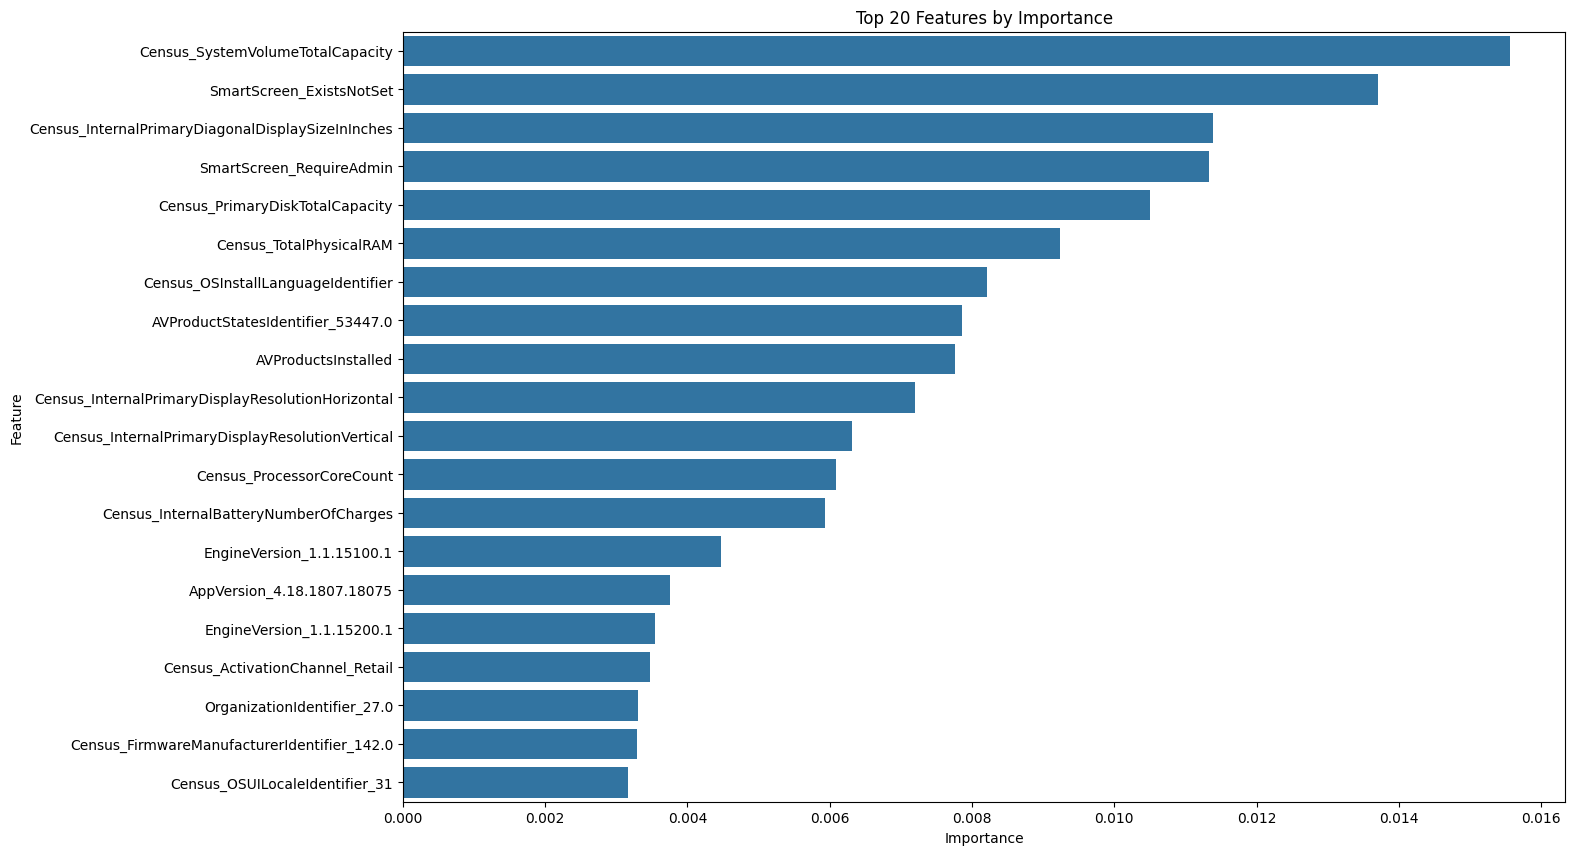


--- Top Rows with Missing Values ---
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScreen           3604               36.04
15                 OrganizationIdentifier           3028               30.28
29                                  SMode            609                6.09
14                         CityIdentifier            383                3.83
53  Census_InternalBatteryNumberOfChar

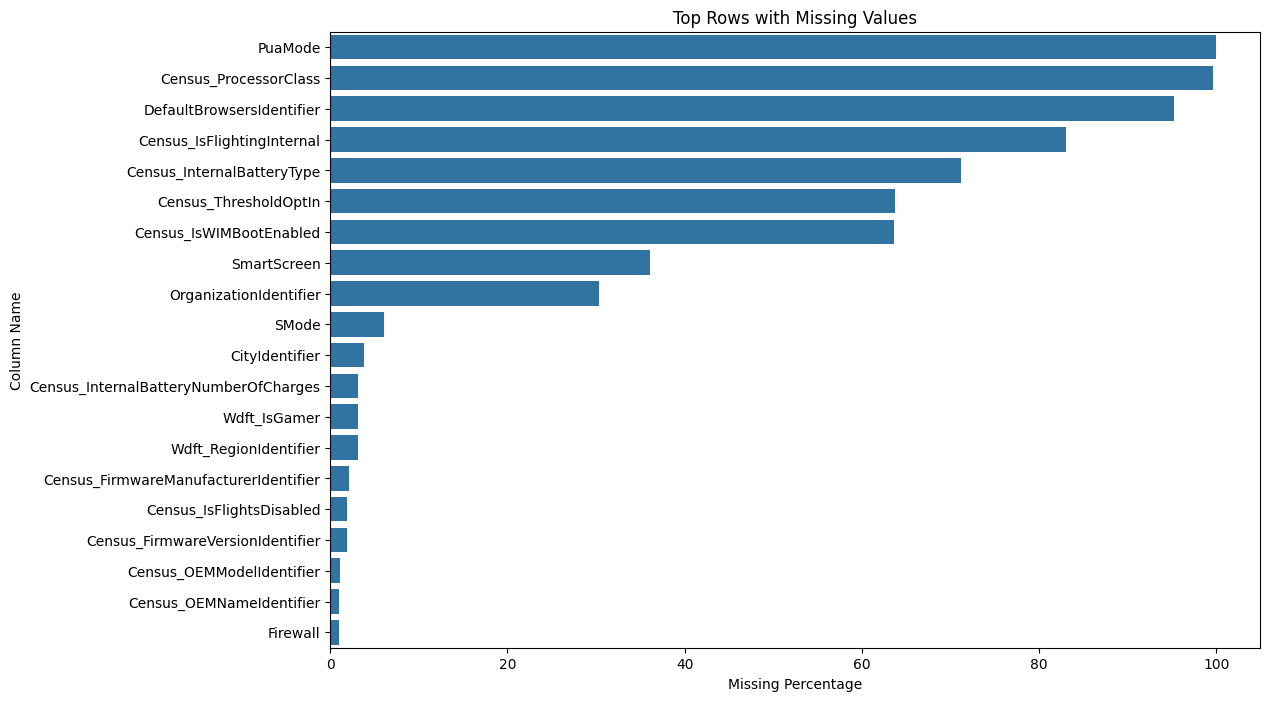

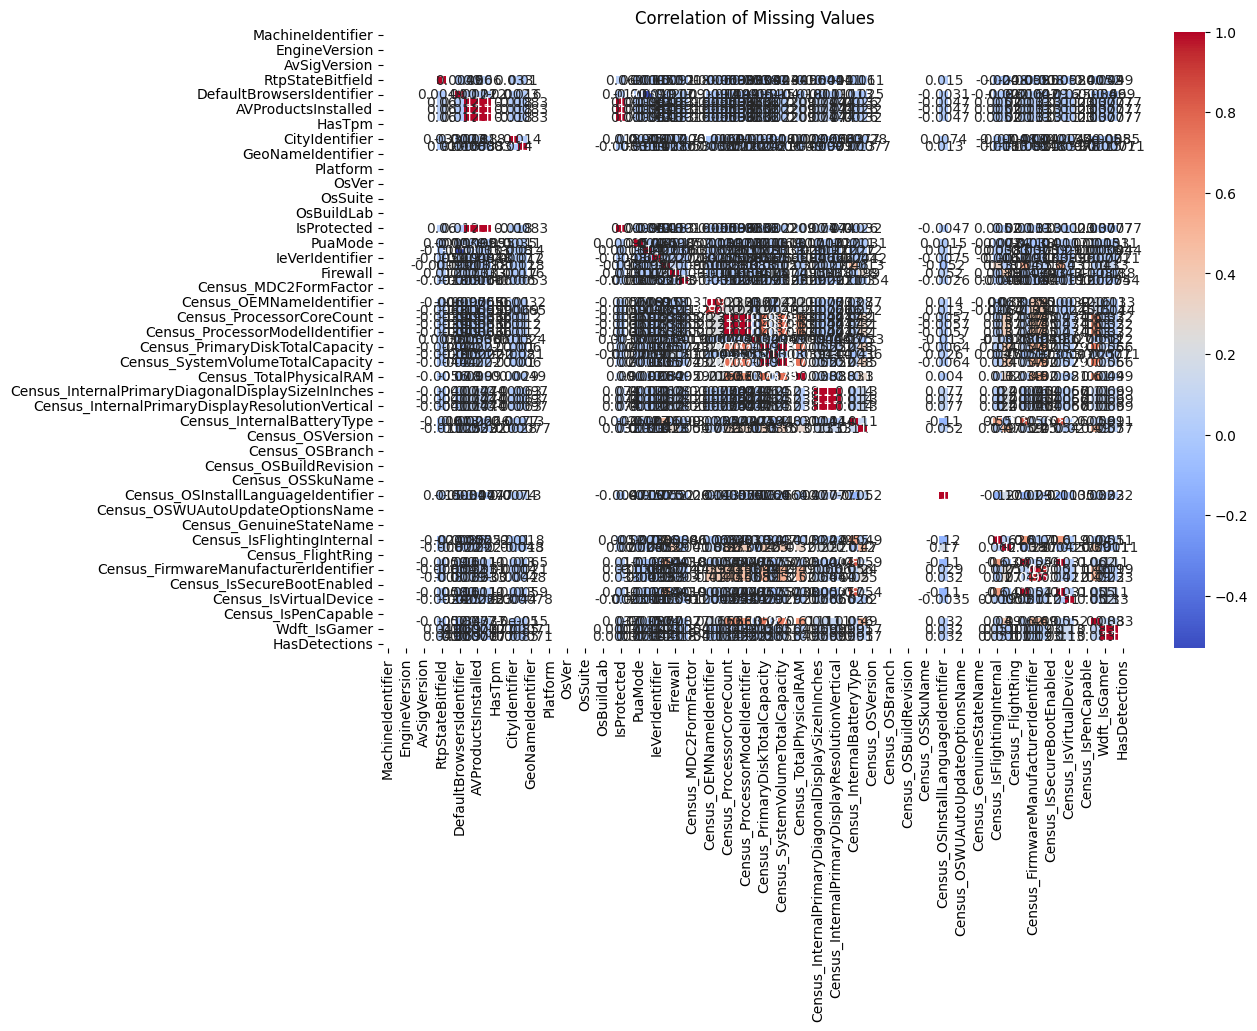

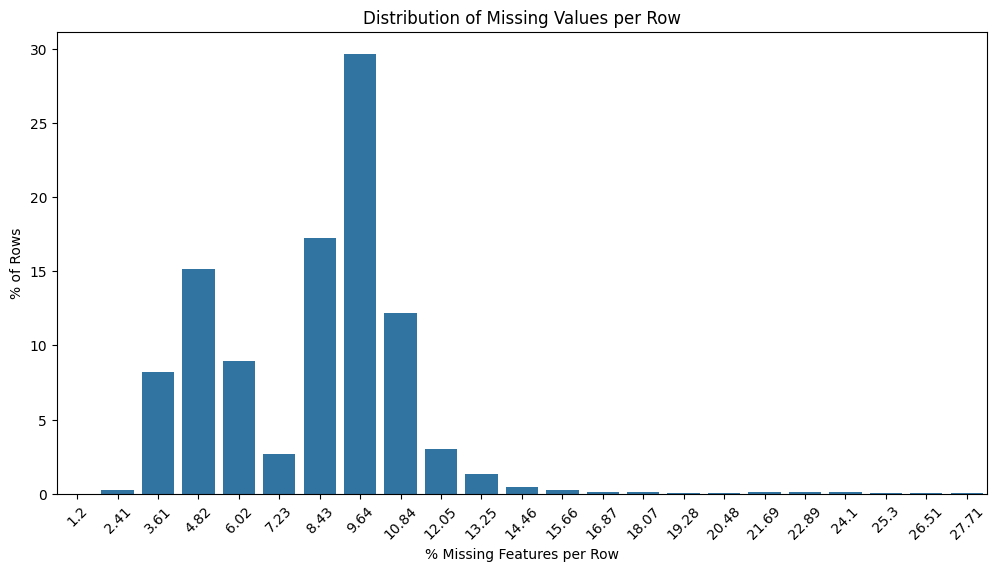


--- Distribution of Missing Values per Row ---
 missing features per row  % missing features per row  % of rows
                       23                   27.710843       0.03
                       22                   26.506024       0.02
                       21                   25.301205       0.05
                       20                   24.096386       0.10
                       19                   22.891566       0.11
                       18                   21.686747       0.13
                       17                   20.481928       0.04
                       16                   19.277108       0.05
                       15                   18.072289       0.10
                       14                   16.867470       0.13
                       13                   15.662651       0.25
                       12                   14.457831       0.42
                       11                   13.253012       1.33
                       10                 

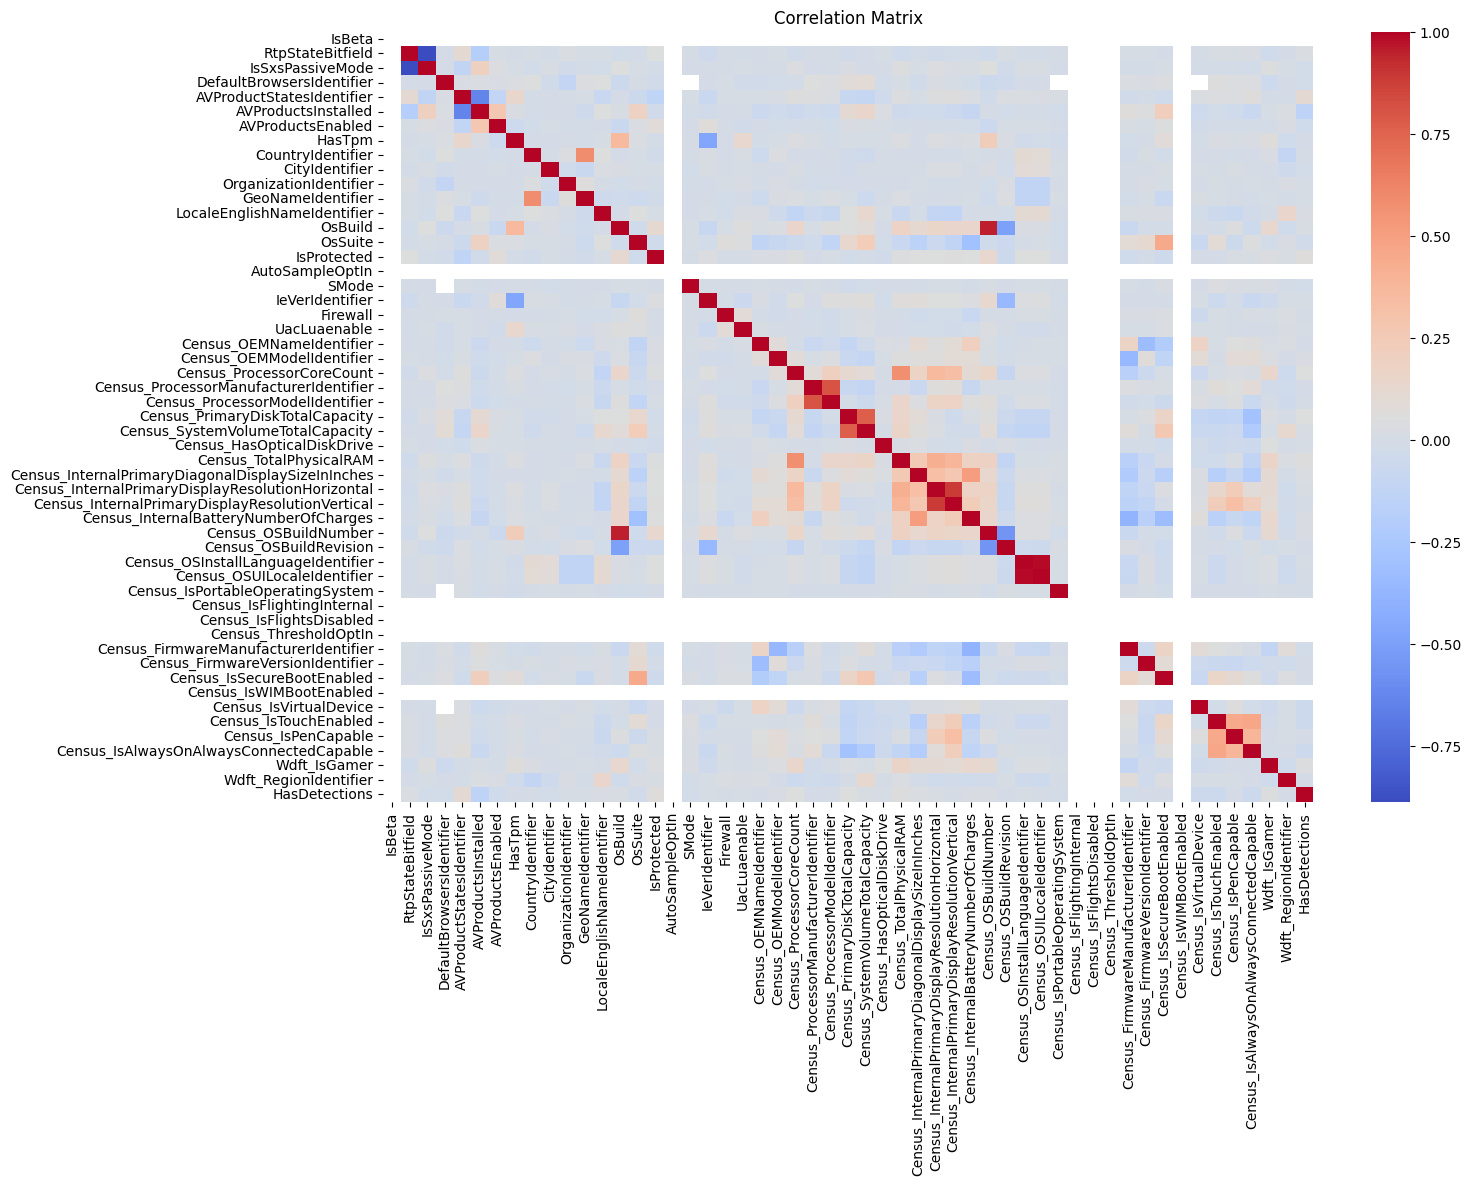


High Correlation Pairs (absolute value > 0.2 or < -0.2):

Census_OSUILocaleIdentifier                        Census_OSInstallLanguageIdentifier                   0.988793
Census_OSBuildNumber                               OsBuild                                              0.950950
Census_InternalPrimaryDisplayResolutionHorizontal  Census_InternalPrimaryDisplayResolutionVertical      0.885465
Census_ProcessorModelIdentifier                    Census_ProcessorManufacturerIdentifier               0.803918
Census_SystemVolumeTotalCapacity                   Census_PrimaryDiskTotalCapacity                      0.768164
CountryIdentifier                                  GeoNameIdentifier                                    0.585682
Census_ProcessorCoreCount                          Census_TotalPhysicalRAM                              0.579974
Census_InternalBatteryNumberOfCharges              Census_InternalPrimaryDiagonalDisplaySizeInInches    0.511199
Census_IsTouchEnabled                

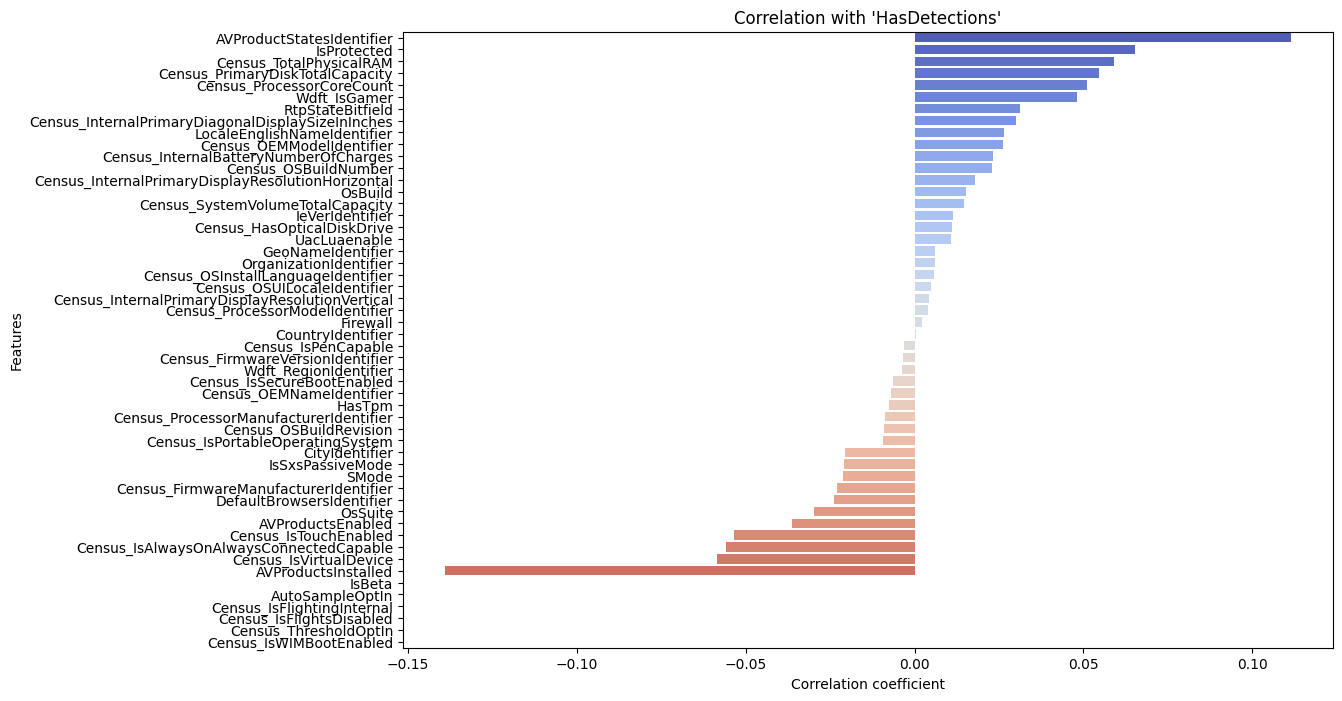


Correlation with 'HasDetections':
 AVProductStatesIdentifier                            0.111348
IsProtected                                          0.065207
Census_TotalPhysicalRAM                              0.059147
Census_PrimaryDiskTotalCapacity                      0.054558
Census_ProcessorCoreCount                            0.050934
Wdft_IsGamer                                         0.047980
RtpStateBitfield                                     0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.029988
LocaleEnglishNameIdentifier                          0.026584
Census_OEMModelIdentifier                            0.026206
Census_InternalBatteryNumberOfCharges                0.023367
Census_OSBuildNumber                                 0.022802
Census_InternalPrimaryDisplayResolutionHorizontal    0.017849
OsBuild                                              0.015204
Census_SystemVolumeTotalCapacity                     0.014634
IeVerIdentifier                   

In [4]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, ensure_directories_exist, save_feature_importance, save_json_file
from src.analysis.missing_values_analysis import (
    missing_values_summary,
    plot_missing_values,
    missing_values_correlation,
    plot_missing_values_correlation,
    missing_count_per_row,
    plot_missing_count_per_row,
    calculate_missing_values_correlation,
    high_missing_value_correlation_pairs,
    prepare_data_and_split,
    analyze_missing_values,
    analyze_missing_values_correlation,
    analyze_missing_values_pattern
)
from src.analysis.data_understanding import correlation_analysis
from src.model.missing_values_training import train_model_and_extract_feature_importance

def main():
    # Load paths and data
    paths = load_paths()
    ensure_directories_exist(paths)
    train_sample, test_sample = load_sample_data(nrows=10000)

    # Prepare data and split
    X_train, X_test, y_train, y_test, numeric_features, categorical_features, feature_metadata = prepare_data_and_split(train_sample, paths)

    # Train model and extract feature importance
    importance_df = train_model_and_extract_feature_importance(X_train, y_train, numeric_features, categorical_features, feature_metadata)
    
    # Display and save feature importance
    print("\n--- Top 20 Features by Importance ---")
    print(importance_df.head(20))
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(os.path.join(paths['reports']['figures']['missing_values'], 'feature_importance.png'))
    plt.show()
    save_feature_importance(importance_df, os.path.join(paths['reports']['analysis_results'], 'feature_importance.json'))

    # Perform Missing Values Analysis
    analyze_missing_values(train_sample, paths)

    # Correlation Analysis of Missing Values
    analyze_missing_values_correlation(train_sample, paths)

    # Pattern Analysis: Count of Missing Values per Row
    analyze_missing_values_pattern(train_sample, paths)

    # Calculate feature correlation matrix
    numeric_columns = train_sample.select_dtypes(include=['int64', 'float64']).columns
    feature_corr_matrix = train_sample[numeric_columns].corr()

    # Use correlation_analysis function to find high correlation pairs for features
    high_corr_pairs, _ = correlation_analysis(dataframe=train_sample)

    # Convert tuple keys to strings for JSON serialization
    high_corr_pairs_dict = {str(k): v for k, v in high_corr_pairs.to_dict().items()}

    # Save high correlation pairs
    save_json_file(high_corr_pairs_dict, os.path.join(paths['reports']['analysis_results'], 'high_missing_value_correlation_pairs.json'))

    # Guidance
    print("\n--- Guidance for Feature Correlation with Target ---")
    print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
    print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
    print("Focus on these features for feature engineering and model building.")

    print("\n--- Contextual Insights and Recommendations ---")
    print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
    print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
    print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
    print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
    print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
    print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

# Run the main function
if __name__ == "__main__":
    main()



--- Top 20 Features by Importance ---
                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.00

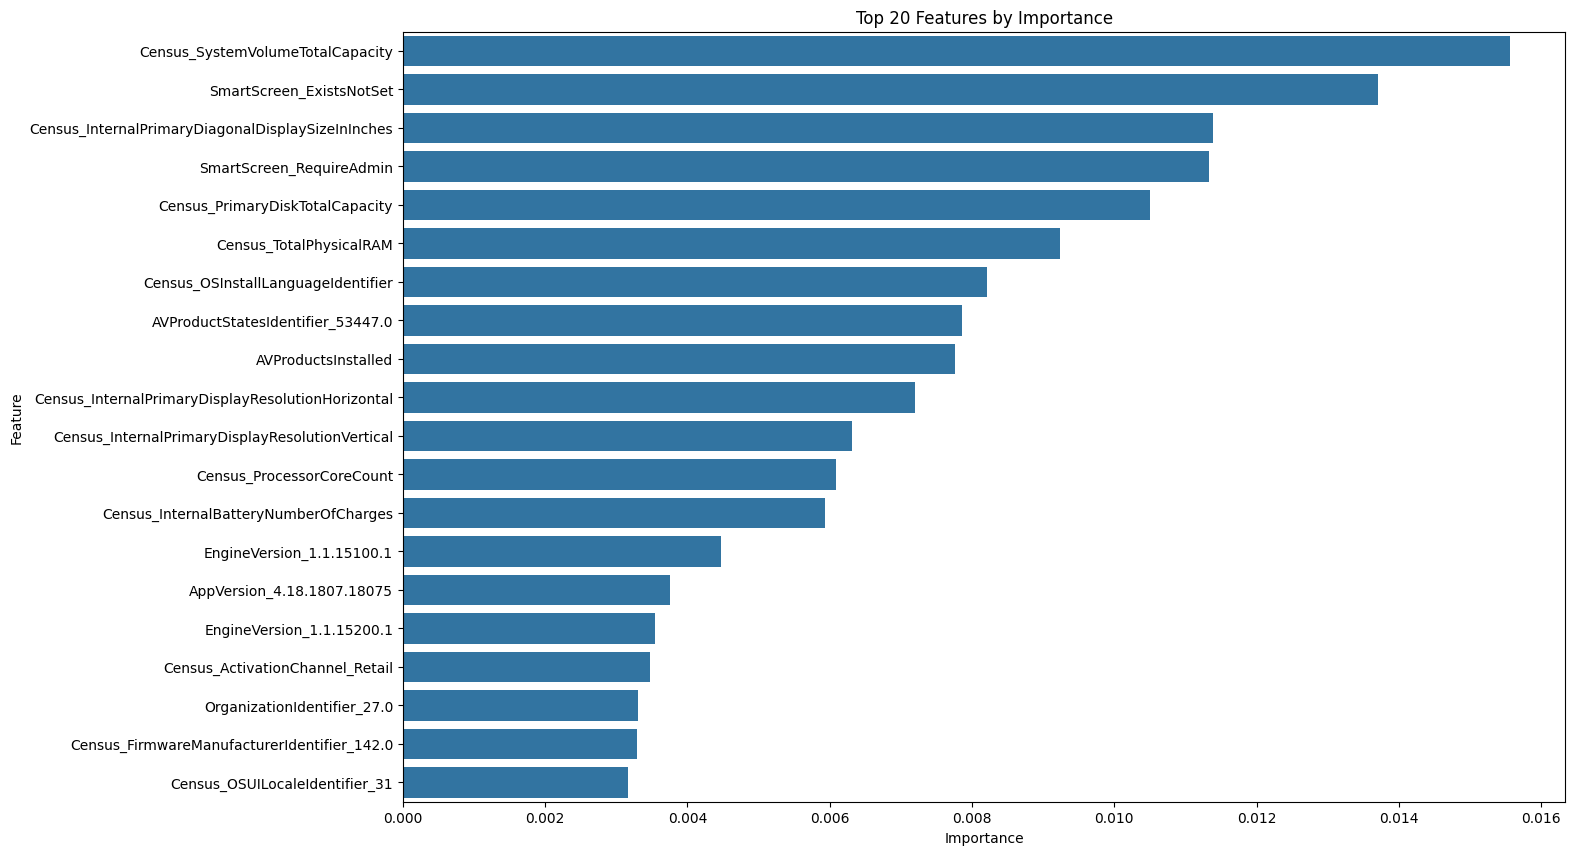


--- Top Rows with Missing Values ---
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScreen           3604               36.04
15                 OrganizationIdentifier           3028               30.28
29                                  SMode            609                6.09
14                         CityIdentifier            383                3.83
53  Census_InternalBatteryNumberOfChar

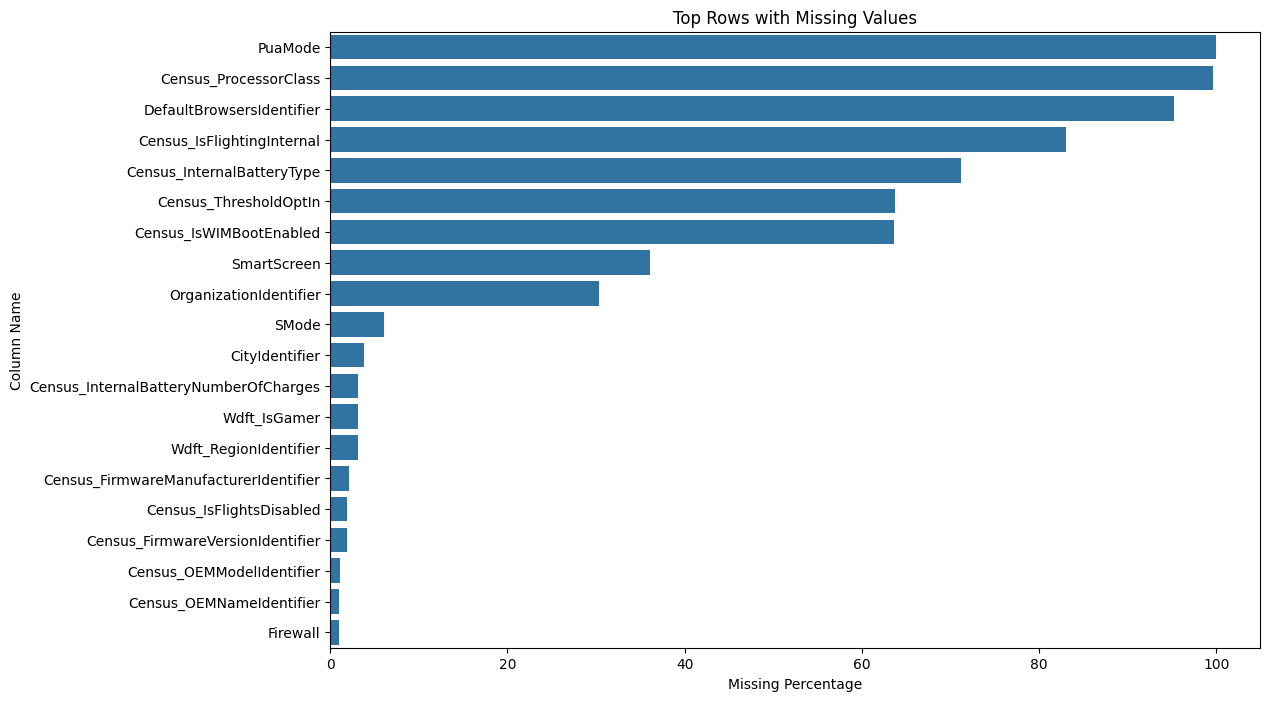

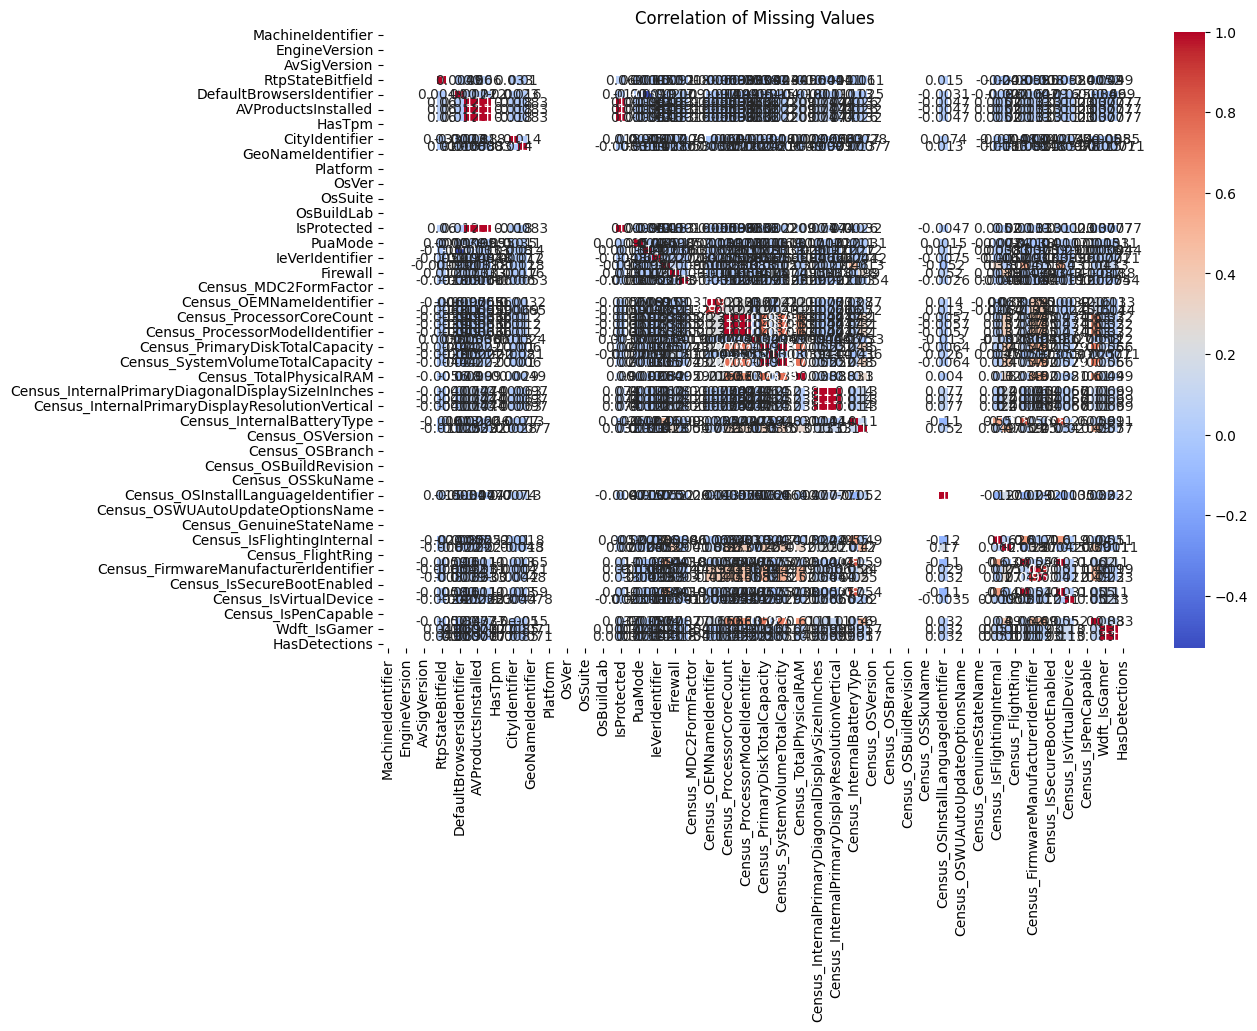

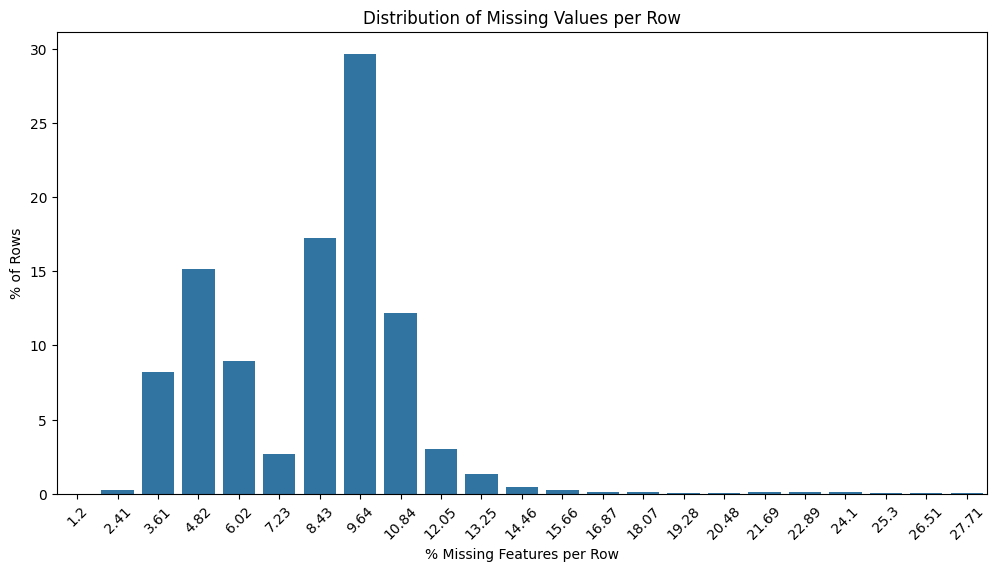


--- Distribution of Missing Values per Row ---
 missing features per row  % missing features per row  % of rows
                       23                   27.710843       0.03
                       22                   26.506024       0.02
                       21                   25.301205       0.05
                       20                   24.096386       0.10
                       19                   22.891566       0.11
                       18                   21.686747       0.13
                       17                   20.481928       0.04
                       16                   19.277108       0.05
                       15                   18.072289       0.10
                       14                   16.867470       0.13
                       13                   15.662651       0.25
                       12                   14.457831       0.42
                       11                   13.253012       1.33
                       10                 

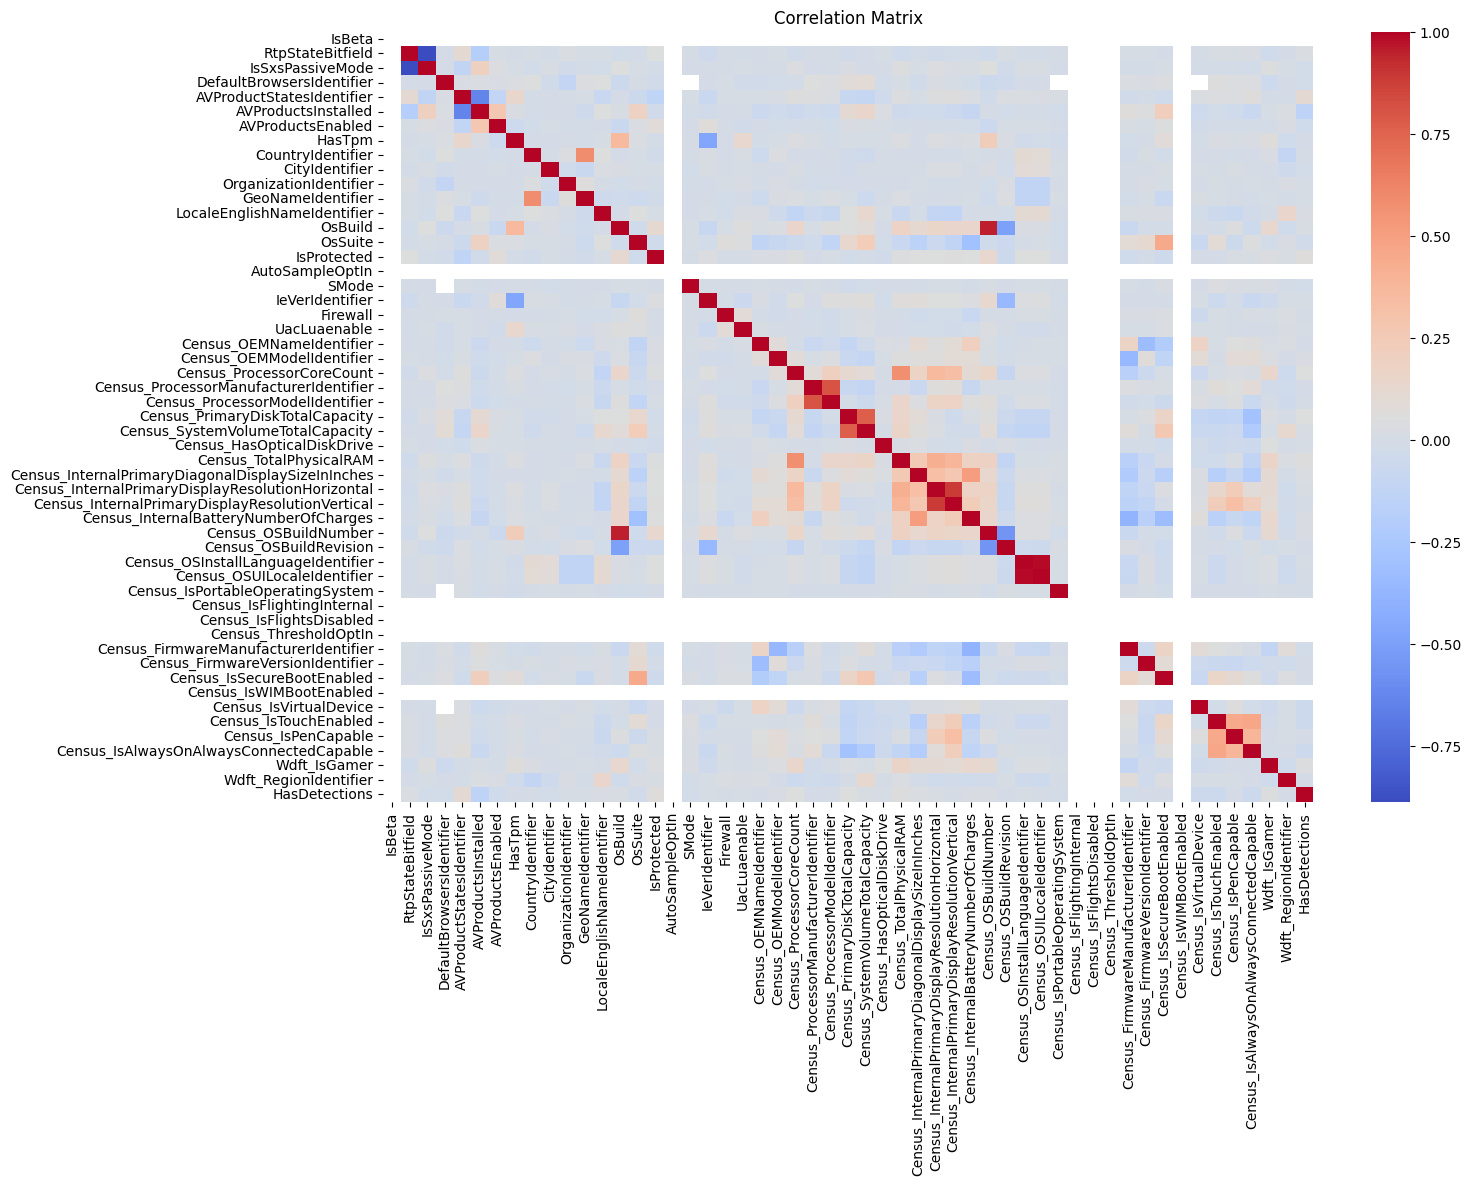


High Correlation Pairs (absolute value > 0.2 or < -0.2):

Census_OSUILocaleIdentifier                        Census_OSInstallLanguageIdentifier                   0.988793
Census_OSBuildNumber                               OsBuild                                              0.950950
Census_InternalPrimaryDisplayResolutionHorizontal  Census_InternalPrimaryDisplayResolutionVertical      0.885465
Census_ProcessorModelIdentifier                    Census_ProcessorManufacturerIdentifier               0.803918
Census_SystemVolumeTotalCapacity                   Census_PrimaryDiskTotalCapacity                      0.768164
CountryIdentifier                                  GeoNameIdentifier                                    0.585682
Census_ProcessorCoreCount                          Census_TotalPhysicalRAM                              0.579974
Census_InternalBatteryNumberOfCharges              Census_InternalPrimaryDiagonalDisplaySizeInInches    0.511199
Census_IsTouchEnabled                

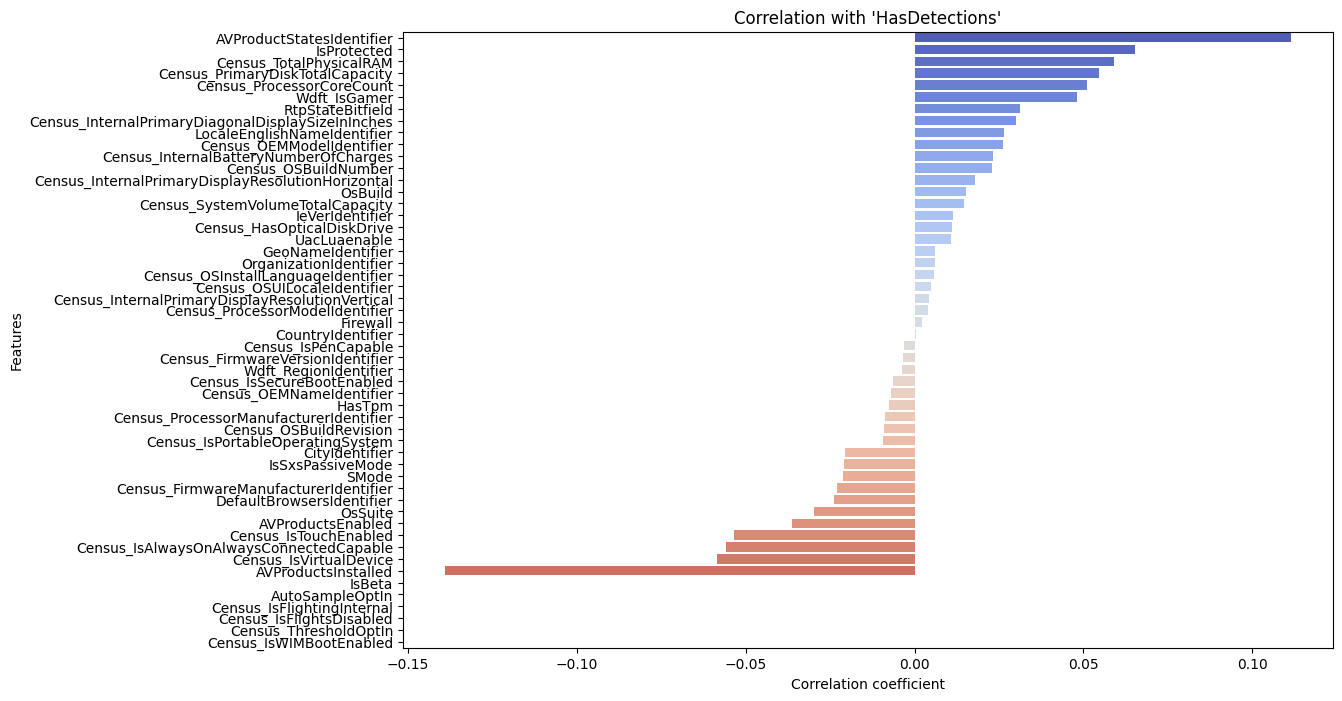


Correlation with 'HasDetections':
 AVProductStatesIdentifier                            0.111348
IsProtected                                          0.065207
Census_TotalPhysicalRAM                              0.059147
Census_PrimaryDiskTotalCapacity                      0.054558
Census_ProcessorCoreCount                            0.050934
Wdft_IsGamer                                         0.047980
RtpStateBitfield                                     0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.029988
LocaleEnglishNameIdentifier                          0.026584
Census_OEMModelIdentifier                            0.026206
Census_InternalBatteryNumberOfCharges                0.023367
Census_OSBuildNumber                                 0.022802
Census_InternalPrimaryDisplayResolutionHorizontal    0.017849
OsBuild                                              0.015204
Census_SystemVolumeTotalCapacity                     0.014634
IeVerIdentifier                   

In [4]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, ensure_directories_exist, save_feature_importance, save_json_file
from src.analysis.missing_values_analysis import (
    missing_values_summary,
    plot_missing_values,
    missing_values_correlation,
    plot_missing_values_correlation,
    missing_count_per_row,
    plot_missing_count_per_row,
    calculate_missing_values_correlation,
    high_missing_value_correlation_pairs,
    prepare_data_and_split,
    analyze_missing_values,
    analyze_missing_values_correlation,
    analyze_missing_values_pattern
)
from src.analysis.data_understanding import correlation_analysis
from src.model.missing_values_training import train_model_and_extract_feature_importance

def main():
    # Load paths and data
    paths = load_paths()
    ensure_directories_exist(paths)
    train_sample, test_sample = load_sample_data(nrows=10000)

    # Prepare data and split
    X_train, X_test, y_train, y_test, numeric_features, categorical_features, feature_metadata = prepare_data_and_split(train_sample, paths)

    # Train model and extract feature importance
    importance_df = train_model_and_extract_feature_importance(X_train, y_train, numeric_features, categorical_features, feature_metadata)
    
    # Display and save feature importance
    print("\n--- Top 20 Features by Importance ---")
    print(importance_df.head(20))
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(os.path.join(paths['reports']['figures']['missing_values'], 'feature_importance.png'))
    plt.show()
    save_feature_importance(importance_df, os.path.join(paths['reports']['analysis_results'], 'feature_importance.csv'))

    # Perform Missing Values Analysis
    analyze_missing_values(train_sample, paths)

    # Correlation Analysis of Missing Values
    analyze_missing_values_correlation(train_sample, paths)

    # Pattern Analysis: Count of Missing Values per Row
    analyze_missing_values_pattern(train_sample, paths)

    # Calculate feature correlation matrix
    numeric_columns = train_sample.select_dtypes(include=['int64', 'float64']).columns
    feature_corr_matrix = train_sample[numeric_columns].corr()

    # Use correlation_analysis function to find high correlation pairs for features
    high_corr_pairs, _ = correlation_analysis(dataframe=train_sample)

    # Convert tuple keys to strings for JSON serialization
    high_corr_pairs_dict = {str(k): v for k, v in high_corr_pairs.to_dict().items()}

    # Save high correlation pairs
    save_json_file(high_corr_pairs_dict, os.path.join(paths['reports']['high_missing_value_correlation_pairs']))

    # Guidance
    print("\n--- Guidance for Feature Correlation with Target ---")
    print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
    print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
    print("Focus on these features for feature engineering and model building.")

    print("\n--- Contextual Insights and Recommendations ---")
    print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
    print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
    print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
    print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
    print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
    print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

# Run the main function
if __name__ == "__main__":
    main()


# Handling Missing Values: A Structured Guide

## Introduction
- **Purpose**: To provide a comprehensive guide on handling missing values in datasets.
- **Importance**: Missing values can significantly affect the performance of machine learning models and the validity of statistical analyses.
- **Scope**: This guide covers techniques for identifying, analyzing, and handling missing values in data.

## Understanding Missing Values
### Types of Missing Data
- **Missing Completely at Random (MCAR)**: The missingness is independent of both observed and unobserved data.
- **Missing at Random (MAR)**: The missingness is related to the observed data but not the unobserved data.
- **Missing Not at Random (MNAR)**: The missingness is related to the unobserved data.

### Impact on Analysis and Modeling
- **Bias**: How missing data can introduce bias into analysis.
- **Reduction in Data Quality**: The effect on the dataset's overall quality and the accuracy of models.
- **Loss of Information**: How missing data can lead to the loss of valuable information.

## Identifying Missing Values
### Initial Data Exploration
- **Descriptive Statistics**: Summary statistics to identify missing values.
- **Visualizations**: Heatmaps, bar plots, and histograms to visualize missing data patterns.

### Tools and Techniques
- **Pandas**: Using `isnull()` and `sum()` functions.
- **Missingno**: Visualizing missing data with the `missingno` library.
- **Seaborn**: Heatmaps to identify patterns in missing data.

## Analyzing Missing Values
### Quantifying Missing Data
- **Percentage of Missing Values**: Calculating the percentage of missing values in each column.
- **Missing Data Patterns**: Identifying patterns and correlations in missing data.

### Visual Analysis
- **Missing Value Heatmaps**: Using heatmaps to visualize the distribution of missing data.
- **Bar Plots**: Displaying the number of missing values per column.
- **Histograms**: Visualizing the distribution of missing values across rows.

## Handling Missing Values
### Strategies Overview
- **Deletion**: Removing missing data points or entire rows/columns.
- **Imputation**: Filling in missing data using various techniques.
- **Model-Based Methods**: Using algorithms to predict and fill missing values.

### Deletion Methods
- **Listwise Deletion**: Removing rows with any missing values.
- **Pairwise Deletion**: Removing data points only when necessary for a specific analysis.
- **Considerations**: When deletion is appropriate and its drawbacks.

### Imputation Techniques
- **Mean/Median/Mode Imputation**: Replacing missing values with the mean, median, or mode of the column.
- **Forward/Backward Fill**: Using adjacent values to fill in missing data.
- **K-Nearest Neighbors (KNN) Imputation**: Using the KNN algorithm to estimate missing values.
- **Multiple Imputation**: Creating multiple imputations to account for the uncertainty of missing values.

### Model-Based Methods
- **Regression Imputation**: Using regression models to predict and fill missing values.
- **Random Forest Imputation**: Leveraging random forests to handle missing data.
- **Advanced Algorithms**: Utilizing machine learning algorithms for more complex imputations.

### Handling High, Moderate, and Low Missing Values

#### High Percentage of Missing Values (>50%)
- **Action**: Consider dropping these features as imputation might introduce significant bias and uncertainty.

#### Moderate Percentage of Missing Values (10%-50%)
- **Action**: Use advanced imputation methods such as KNN, regression imputation, or multiple imputation. Monitor the impact on model performance.

#### Low Percentage of Missing Values (<10%)
- **Action**: Use simple imputation methods such as mean, median, or mode imputation. The low percentage of missing data typically has minimal impact on the overall dataset quality.

## Correlation-Based Handling of Missing Values

### Importance of Correlation Magnitude
When evaluating the significance of correlations for handling missing values, the order of magnitude (absolute value) of the correlation coefficient is what matters, rather than the direction (positive or negative). 

### Thresholds for Handling Missing Values Based on Correlations

#### i) Feature Correlation with Target
- **High Correlation (|correlation| > 0.7)**:
  - Strong relationship with the target variable.
  - **Action**: Retain these features and ensure accurate imputation. Consider advanced imputation methods to preserve their predictive power.
  
- **Moderate Correlation (0.3 < |correlation| ≤ 0.7)**:
  - Moderate relationship with the target variable.
  - **Action**: Impute missing values using appropriate methods like KNN or regression imputation. These features are potentially useful and should be explored further.

- **Low Correlation (|correlation| ≤ 0.3)**:
  - Weak or no relationship with the target variable.
  - **Action**: Consider simple imputation methods (mean/median/mode) if missing values are present. If the feature has a high percentage of missing values, consider dropping it.

#### ii) Missing Value Correlation with Target
- **High Correlation (|correlation| > 0.7)**:
  - Strong relationship between the presence of missing values and the target variable.
  - **Action**: Treat the presence of missing values as a separate feature. Impute missing values carefully to avoid losing significant information.

- **Moderate Correlation (0.3 < |correlation| ≤ 0.7)**:
  - Moderate relationship between the presence of missing values and the target variable.
  - **Action**: Impute missing values using advanced methods like KNN or model-based imputation. Monitor the impact on model performance.

- **Low Correlation (|correlation| ≤ 0.3)**:
  - Weak or no relationship between the presence of missing values and the target variable.
  - **Action**: Use simple imputation methods. If the feature has a high percentage of missing values, consider dropping it.

#### iii) Feature Pair Correlation
- **High Correlation (|correlation| > 0.7)**:
  - Strong multicollinearity between features.
  - **Action**: Consider removing one of the highly correlated features to reduce redundancy. Alternatively, use dimensionality reduction techniques like PCA.

- **Moderate Correlation (0.3 < |correlation| ≤ 0.7)**:
  - Moderate relationship between features.
  - **Action**: Monitor multicollinearity and adjust the model accordingly. These features might provide complementary information.

- **Low Correlation (|correlation| ≤ 0.3)**:
  - Weak or no relationship between features.
  - **Action**: No specific action required regarding multicollinearity. Retain both features if they are individually relevant.

#### iv) Missing Value Pair Correlation
- **High Correlation (|correlation| > 0.7)**:
  - Strong relationship between the patterns of missing values in different features.
  - **Action**: Investigate the underlying cause of the correlation. Consider imputing missing values together using methods like multiple imputation to maintain consistency.

- **Moderate Correlation (0.3 < |correlation| ≤ 0.7)**:
  - Moderate relationship between the patterns of missing values in different features.
  - **Action**: Use advanced imputation methods that consider correlations between features. Ensure that the imputation preserves the relationship between features.

- **Low Correlation (|correlation| ≤ 0.3)**:
  - Weak or no relationship between the patterns of missing values in different features.
  - **Action**: Impute missing values independently. Simple imputation methods are generally sufficient.

### Recommended Actions Based on Correlation Scenarios

| Scenario                                                                                       | Description                                                                                                   | Recommended Action                                                                                   |
|------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **i) Low Feature Correlation with Target, Low Missing Value Correlation with Target, High Feature Pair Correlation, High Missing Value Pair Correlation** | Features have low importance for predicting the target.<br>High correlation with other features.<br>High correlation in missing value patterns. | Consider feature redundancy and remove one if necessary.<br>Use advanced imputation methods like multiple imputation.<br>Consider dimensionality reduction techniques. |
| **ii) Low Feature Correlation with Target, Low Missing Value Correlation with Target, Moderate Feature Pair Correlation, Moderate Missing Value Pair Correlation** | Features have low importance for predicting the target.<br>Moderate correlation with other features.<br>Moderate correlation in missing value patterns. | Use simple imputation methods.<br>Monitor multicollinearity and adjust the model.<br>Retain both features unless there are strong reasons to drop one. |
| **iii) Low Feature Correlation with Target, Low Missing Value Correlation with Target, Low Feature Pair Correlation, Low Missing Value Pair Correlation** | Features have low importance for predicting the target.<br>Low correlation with other features.<br>Low correlation in missing value patterns. | Evaluate the importance of the feature.<br>Consider dropping if the feature is not crucial and has a high percentage of missing values.<br>Use simple imputation methods if retained. |

### Conclusion
Handling missing values is crucial for maintaining the integrity and performance of your data analysis and machine learning models. By following a structured approach, you can ensure that missing values are appropriately addressed, reducing bias and preserving the predictive power of your dataset. Regularly validate your methods to ensure their effectiveness and make necessary adjustments based on the data and analysis goals.

### References
- **Books and Articles**: Key literature on missing data and imputation techniques.
- **Online Resources**: Links to tutorials, documentation, and tools for handling


### Professional Guidance on Missing Values Strategy

Effectively handling missing values is crucial in building robust and reliable machine learning models. To navigate the decision-making process, we will leverage multiple metrics to evaluate missing values and follow a structured approach. Here are the key steps and considerations:

#### 1. Identify and Understand Missing Values
- **Percent Missing Values**: Calculate the percentage of missing values for each feature. This gives a quick overview of the extent of missing data.
  - **Action**: 
    - Features with more than 50% missing values should be considered for removal unless they hold critical information.
    - For features with 10%-50% missing values, consider using domain-specific imputation techniques.
    - Features with less than 10% missing values can be imputed using simple techniques like mean/median/mode imputation.

#### 2. Evaluate Feature Importance
- **Feature Importance**: Determine the importance of each feature in predicting the target variable using models such as Random Forest. This helps identify key features that should be retained.
  - **Action**: 
    - High importance features should be prioritized for careful imputation or engineering.
    - Low importance features may be candidates for removal if they have high missing rates.

#### 3. Assess Correlation with Target Feature
- **Feature Correlation with Target Feature**: Evaluate the correlation of each feature with the target variable. This helps in understanding the predictive power of the features.
  - **Action**: 
    - Features with high absolute correlation values (closer to 1 or -1) indicate a strong relationship with the target and should be retained and imputed carefully.

- **Missing Value Correlation with Target Feature**: Assess how the presence of missing values in a feature correlates with the target variable.
  - **Action**: 
    - If the presence of missing values is highly correlated with the target, consider using missingness as an indicator feature in the model.

#### 4. Analyze Pair Correlations
- **Feature Pair Correlations**: Examine the correlations between pairs of features to identify multicollinearity.
  - **Action**: 
    - Highly correlated features (absolute value > 0.7) may introduce multicollinearity. Consider removing or combining such features to reduce redundancy.

- **Missing Value Pair Correlations**: Analyze correlations between pairs of features based on their missing values.
  - **Action**: 
    - High correlations between missing values can indicate a pattern or dependency. Investigate the cause and consider joint imputation strategies.

#### 5. Pattern Analysis of Missing Values per Row
- **Missing Values per Row**: Calculate the number of missing values per row and analyze their distribution.
  - **Action**: 
    - Rows with a high number of missing values can distort the model if left untreated. Consider removing rows with more than a certain threshold of missing values (e.g., more than 50%) or applying more sophisticated imputation techniques.

### Decision-Making Process

#### Initial Assessment:
1. Calculate the percentage of missing values for each feature.
2. Identify features with more than 50% missing values for potential removal.
3. Prioritize features with high importance and significant correlations with the target for imputation.

#### Correlation Analysis:
1. Evaluate feature correlations with the target and with each other.
2. Assess missing value correlations with the target and among features.
3. Consider creating new features based on missingness patterns if correlated with the target.

#### Imputation Strategy:
1. For features with high importance and low missing percentages, use mean/median/mode imputation.
2. For features with moderate missing percentages, consider regression or machine learning-based imputation.
3. For features with high missing percentages, investigate domain-specific imputation techniques or consider removal if not critical.

#### Final Review:
1. Analyze the distribution of missing values per row.
2. Decide on row removal thresholds or advanced imputation techniques for rows with high missing values.
3. Ensure no significant information loss by validating the imputed dataset.

### Weight and Importance of Metrics

The relative importance of these metrics depends on the specific dataset and the problem at hand. Generally, the weight given to each metric can be prioritized as follows:

1. **Feature Importance**: Most crucial, as it directly impacts the predictive power of the model.
2. **Percent Missing Values**: Important for initial filtering and deciding on imputation strategies.
3. **Feature Correlation with Target Feature**: Significant for understanding the relationship between features and the target.
4. **Missing Value Correlation with Target Feature**: Useful for considering missingness as a feature.
5. **Feature Pair Correlations**: Essential for identifying and mitigating multicollinearity.
6. **Missing Value Pair Correlations**: Helps in understanding patterns and dependencies in missing data.
7. **Missing Values per Row**: Guides the treatment of rows with many missing values to avoid bias and distortion in the model.

Ultimately, the decision-making process should be flexible and consider the context of the data and the specific modeling goals.
